# Th analysis

In [1]:
%matplotlib inline

import os
import random
import sys
import textwrap

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy  as np
import tables as tb

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.paolina_functions as plf

from   collections                             import namedtuple
from   invisible_cities.io.hits_io             import load_hits
from   invisible_cities.io.hits_io             import load_hits_skipping_NN
from   invisible_cities.evm.event_model        import Hit, Cluster, HitCollection
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.types.ic_types         import NN
from   invisible_cities.core.system_of_units_c import units
from   matplotlib.patches                      import Ellipse
from   mpl_toolkits.mplot3d                    import Axes3D

In [2]:
# code from Gonzalo
def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (1592/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*f.values[1:], *reso(f.values)))

## Read the corrections table
Reads the corrections table from the specified file and creates a function that returns the correction factor for a given (x,y) location.

In [3]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4168/run4168_corrections.h5"
ncbins = 54

Correction table with shape: (50, 50); bin sizes (7.9199981689453125,7.9199981689453125)


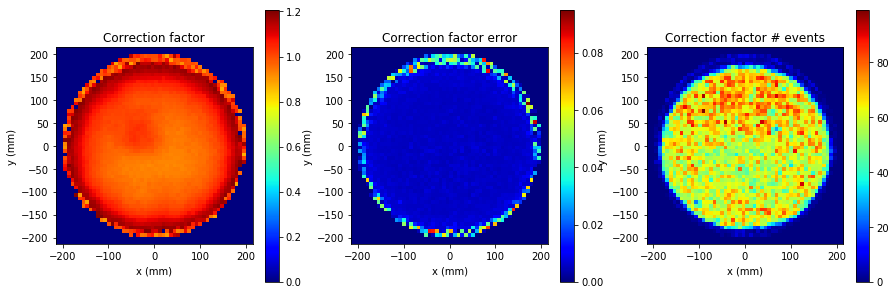

In [4]:
fcorr = tb.open_file(corr_file,'r')

# Fill arrays containing the information in the correction table.
corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf = np.max(corr_fs)

# ---------------------------------------------
# Plots

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor
ax1 = fig.add_subplot(131);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=maxf)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(132)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics
ax3 = fig.add_subplot(133)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

# get the x and y bin sizes
xdiff = corr_x[1:] - corr_x[0:-1]
nz_xdiff = np.nonzero(xdiff)[0]
xbin = xdiff[nz_xdiff][0]
xcmin = np.min(corr_x)

ydiff = corr_y[1:] - corr_y[0:-1]
nz_ydiff = np.nonzero(ydiff)[0]
ybin = ydiff[np.nonzero(ydiff)][0]
ycmin = np.min(corr_y)

# ---------------------------------------------------
# Create the correction factor table.

ctbl = np.ones([len(nz_xdiff)+1,len(nz_xdiff)+1])-2
for x,y,fs in zip(corr_x,corr_y,corr_fs):
    xb = int((x-xcmin)/xbin)
    yb = int((y-ycmin)/ybin)
    ctbl[xb][yb] = fs
    #print("Filled ({0},{1}) with {2} for x = {3} and y = {4}".format(xb,yb,fs,x,y))
if(len(ctbl[ctbl < 0]) > 0):
    print("ERROR: value in correction table not filled")
print("Correction table with shape: {0}; bin sizes ({1},{2})".format(ctbl.shape,xbin,ybin))

# Define a function that returns the correction factor for a given (x,y).
def fcorr(x,y):
    xb = max(0,min(ctbl.shape[0]-1,((x-xcmin)/xbin).astype(int)))
    yb = max(0,min(ctbl.shape[1]-1,((y-ycmin)/ybin).astype(int)))

    if hasattr(xb, "__len__"):
        cf = [ctbl[xx][yy] for xx,yy in zip(xb,yb)]
        return cf
    else:
        return ctbl[xb][yb]

## Read in the output of Penthesilea
Reads in Penthesilea output from the runs listed

In [5]:
def merge_NN_hits(hits_all,hits_nonNN):

    # Iterate through both dictionaries (note - assuming same number of events)
    for (evt_all,hc_all),(evt,hc) in zip(hits_all.items(),hits_nonNN.items()):

        if(evt_all != evt):
            print("ERROR: events don't match!")

        # Add energy from all NN hits to hits in closest slice.
        for h1 in hc_all.hits:

            if(h1.Q == NN):

                # Find the hits to which the energy will be added.
                zdist_min = -1
                h_add = []
                for h2 in hc.hits:
                    zdist = np.abs(h1.Z - h2.Z)
                    if(zdist_min < 0 or zdist < zdist_min):
                        zdist_min = zdist
                        h_add = []
                        h_add.append(h2)
                    elif(zdist == zdist_min):
                        h_add.append(h2)

                # Add the energy.
                hadd_etot = sum([ha.E for ha in h_add])
                for ha in h_add:
                    ha.energy += h1.E*(ha.E/hadd_etot)



In [6]:
l_rnum = [4595]
l_tlife = [1400]

In [8]:
l_hitc = []
for rnum in l_rnum:
    
    fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks_{1}.h5".format(rnum,rnum)
    hits_all = load_hits(fname)
    hits = load_hits_skipping_NN(fname)

    # Modifies the list of non-NN hits.
    merge_NN_hits(hits_all,hits)
    
    # Save the hit collection that no longer contains NN hits.
    l_hitc.append(hits)

In [9]:
# Configuration information
tot_Emin = 50000; tot_Emax = 1000000

In [10]:
# Create the corrected hit collection (summed over all runs).
hitc_cevt = []
for hitc, tlife in zip(l_hitc,l_tlife):

    for ee,hc in hitc.items():
        hc_corr = []
        for hh in hc.hits:
            hecorr = hh.E*fcorr(hh.X,hh.Y)/np.exp(-hh.Z/tlife)
            hcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
            hc_corr.append(hcorr)
        hitc_cevt.append(hc_corr)

---------------------------

# Distributions and analysis of all events
At this point we have a list of hit collections for all events from all specified runs, corrected by their appropriate lifetimes.

In [ ]:
# Distribution in R
fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

# event distribution vs. R
ax1 = fig.add_subplot(221);
plt.hist(r_spec,bins=100)
plt.xlabel('r (mm)')
plt.ylabel('Counts/bin')

In [ ]:
# closer look at the energy spectrum
CAL_FACTOR = 1620/486000
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

#y, x, _ = plt.hist(ecorr_slice_spec, 100, range=[300000,800000])
y, x, _ = plt.hist(ec_spec*CAL_FACTOR, 150, range=[300000*CAL_FACTOR,800000*CAL_FACTOR])

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 467e3*CAL_FACTOR, 494e3*CAL_FACTOR)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
plt.plot(x, f.fn(x), "r")
plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

#plt.hist(ecorr_slice_spec,bins=200)
#plt.ylim([100000,900000])
plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

In [ ]:
# Energy vs. z
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.scatter(zc_spec[0:4405],ec_spec[0:4405]*CAL_FACTOR,s=1.5)
#plt.scatter(range(len(ec_spec)),ec_spec*CAL_FACTOR,s=0.5)
#plt.ylim([100000,900000])
#plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

# Paolina analysis

In [ ]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 400],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([15,15,15],dtype=np.int16)    # voxel size
blob_radius = 21.                    # blob radius in mm
ECCUT_LOW = 250000
ECCUT_HIGH = 1000000
DIST_CUT = 100.
EBLOB_CUT = 300000    # do not accept events with a single blob > this energy

In [ ]:
# run Paolina for many events
trk_energies = []; 
l_eblob1 = []; l_eblob2 = []; l_eevt = []; l_etrk = []
for nevt in range(len(hitc_cevt)):
    
    hitc = hitc_cevt[nevt]
    if(len(hitc) < 2): continue
    
    # Calculate event coordinates and corrected energy.
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[nevt]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[nevt]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[nevt]])
    evt_E = sum([hh.E for hh in hitc_cevt[nevt]])
    if(len(hitc_cevt[nevt]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    
    # Make energy and radial cuts.
    if(not (evt_E > ECCUT_LOW and evt_E < ECCUT_HIGH) or evt_R >= 150.):
        continue

    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    #itmax = np.argmax([len(t) for t in trks])
    itmax = np.argmax([sum([vox.E for vox in t.nodes()]) for t in trks])
    etmax = sum([vox.E for vox in trks[itmax].nodes()])
    
    # voxel fraction cut
    #if(len(trks[itmax])/len(voxels) < 0.95):
    #    continue

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)
    if(distances[a][b] < DIST_CUT): continue
    print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_evt),len(trks[itmax]),len(voxels),distances[a][b]))
    
    # add to the distributions if the blob energy does not exceed the upper limit
    if(Eblob1 < EBLOB_CUT and Eblob2 < EBLOB_CUT):
        l_eblob1.append(Eblob1)
        l_eblob2.append(Eblob2)
        l_eevt.append(evt_E)
        l_etrk.append(etmax)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)
l_eevt = np.array(l_eevt)
l_etrk = np.array(l_etrk)

In [ ]:
# Plot Eblob1 vs. Eblob2 in several intervals
nbins_blobs = 25

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(7.5);

# define intervals
eb1_low = 320000; eb1_high = 350000
eb2_low = 465000; eb2_high = 495000
eb3_low = 516600; eb3_high = 910000

# axes
ax_low = 15000; ax_high = 195000

# histogram range
hrange = 230000

# cuts
cuts_1 = ((l_etrk > eb1_low) & (l_etrk < eb1_high))
cuts_2 = ((l_etrk > eb2_low) & (l_etrk < eb2_high))
cuts_3 = ((l_etrk > eb3_low) & (l_etrk < eb3_high))

print("Number of events I1 ({0} keV, {1} keV): {2}".format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR,len(l_eblob1[cuts_1])))
print("Number of events I2 ({0} keV, {1} keV): {2}".format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR,len(l_eblob1[cuts_2])))
print("Number of events I3 ({0} keV, {1} keV): {2}".format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR,len(l_eblob1[cuts_3])))

# interval 1
ax1 = fig.add_subplot(311);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_1]*CAL_FACTOR, l_eblob2[cuts_1]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax1.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("Eblob1 (keV)")
ax1.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp1)

# interval 2
ax2 = fig.add_subplot(312);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_2]*CAL_FACTOR, l_eblob2[cuts_2]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax2.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent2 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp2 = ax2.imshow(hxy, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("Eblob1 (keV)")
ax2.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp2)

# interval 3
ax3 = fig.add_subplot(313);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_3]*CAL_FACTOR, l_eblob2[cuts_3]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax3.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent3 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp3 = ax3.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("Eblob1 (keV)")
ax3.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp3)

In [ ]:
# track-energy spectrum
#CAL_FACTOR = 1600/486000
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

#y, x, _ = plt.hist(ecorr_slice_spec, 100, range=[300000,800000])
y, x, _ = plt.hist(l_etrk[l_eblob1 > 200/CAL_FACTOR]*CAL_FACTOR, 100, range=[300000*CAL_FACTOR,800000*CAL_FACTOR])

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 465e3*CAL_FACTOR, 495e3*CAL_FACTOR)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
plt.plot(x, f.fn(x), "r")
plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

#plt.hist(ecorr_slice_spec,bins=200)
#plt.ylim([100000,900000])
plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(l_etrk[l_eblob1 < 200/CAL_FACTOR],bins=60,label='Single-track')
plt.hist(l_etrk[l_eblob1 > 200/CAL_FACTOR],bins=60,alpha=0.5,label='Double-track')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

In [ ]:
nevt = 5
hitc = hitc_cevt[nevt]
print("Running Paolina for event {0} (event number {1}) with blob radius {2}".format(nevt,evtnum_hitc[nevt],blob_radius))

evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(nevt,evt_E))

voxels = plf.voxelize_hits(hitc,vox_size)
trks = plf.make_track_graphs(voxels,vox_size)
for t in trks:
    etrk = sum([vox.E for vox in t.nodes()])
    trk_energies.append(etrk)
itmax = np.argmax([len(t) for t in trks])
print("Found {0} tracks; max containing {1} voxels; total of {2} voxels".format(len(trks),len(trks[itmax]),len(voxels)))

eblobs = plf.blob_energies(trks[itmax],blob_radius)
iter_eblobs = iter(eblobs)
if(len(eblobs) > 1):
    Eblob1, Eblob2 = next(iter_eblobs), next(iter_eblobs)
else:
    Eblob1 = Eblob2 = next(iter_eblobs)

# get the extremes
distances = plf.shortest_paths(trks[itmax])
exts = plf.find_extrema(distances)
iter_exts = iter(exts)
if(len(exts) > 1):
    a,b = next(iter_exts),next(iter_exts)
else:
    a = b = next(iter_exts)
    
# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
#for vv in trks[itmax]:
for vv in voxels:
    varr_x.append(vv.pos[0])
    varr_y.append(vv.pos[1])
    varr_z.append(vv.pos[2])
    varr_c.append(vv.E)
    
vtrk_max = 1.0*np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = 1.0*np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])
vtrk_len = np.abs(vtrk_max-vtrk_min)
vtrk_max = vtrk_max + 1.0*vtrk_len
vtrk_min = vtrk_min - 1.0*vtrk_len

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_xlim([vtrk_min[0],vtrk_max[0]])
ax1.set_ylim([vtrk_min[1],vtrk_max[1]])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')
ax1.scatter(a.pos[0],a.pos[1],marker='x',s=200,color='red')
ax1.scatter(b.pos[0],b.pos[1],marker='x',s=200,color='red')

# Create the y-z projection.
ax2 = fig.add_subplot(132)
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_xlim([vtrk_min[1],vtrk_max[1]])
ax2.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp2 = plt.colorbar(sp2)
cbp2.set_label('Energy (Q)')
ax2.scatter(a.pos[1],a.pos[2],marker='x',s=200,color='red')
ax2.scatter(b.pos[1],b.pos[2],marker='x',s=200,color='red')

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_xlim([vtrk_min[0],vtrk_max[0]])
ax3.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');
ax3.scatter(a.pos[0],a.pos[2],marker='x',s=200,color='red')
ax3.scatter(b.pos[0],b.pos[2],marker='x',s=200,color='red')

print("Extreme0 at ({0},{1},{2}) with energy {3}".format(a.pos[0],a.pos[1],a.pos[2],Eblob1))
print("Extreme1 at ({0},{1},{2}) with energy {3}".format(b.pos[0],b.pos[1],b.pos[2],Eblob2))

In [ ]:
# plot the clusters in 3D
carr_x = []; carr_y = []; carr_z = []; carr_c = []
for cc in hitc:
    if(cc.E > 1):
        carr_x.append(cc.X)
        carr_y.append(cc.Y)
        carr_z.append(cc.Z)
        carr_c.append(cc.E)

mcarr_x = []; mcarr_y = []; mcarr_z = []; mcarr_c = []
if(nevt < len(hitc_mc)):
    hitcm = hitc_mc[nevt]
    for cc in hitcm:
        mcarr_x.append(cc.X)
        mcarr_y.append(cc.Y)
        mcarr_z.append(cc.Z)
        mcarr_c.append(cc.E)

print(sum(mcarr_c))
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# true track
ax1 = fig.add_subplot(121, projection='3d')
sc3d = ax1.scatter(mcarr_x,mcarr_y,mcarr_z,marker='s',cmap='jet',c=mcarr_c)
xst, xen = ax1.get_xlim(); ax1.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax1.get_ylim(); ax1.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax1.get_zlim(); ax1.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_zlabel("z (mm)")
ax1.set_title("True Track")
lb_x = ax1.get_xticklabels()
lb_y = ax1.get_yticklabels()
lb_z = ax1.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (MeV)')

# reconstructed clusters
ax2 = fig.add_subplot(122, projection='3d')
sc3d = ax2.scatter(carr_x,carr_y,carr_z,marker='s',cmap='jet',c=carr_c)
xst, xen = ax2.get_xlim(); ax2.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax2.get_ylim(); ax2.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax2.get_zlim(); ax2.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")
ax2.set_zlabel("z (mm)")
ax2.set_title("Reconstructed Clusters")
lb_x = ax2.get_xticklabels()
lb_y = ax2.get_yticklabels()
lb_z = ax2.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (Q)')

# Paolina track
#ax3 = fig.add_subplot(133, projection='3d')
#sc3d = ax3.scatter(varr_x,varr_y,varr_z,marker='s',cmap='jet',c=varr_c)
#xst, xen = ax3.get_xlim(); ax3.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
#yst, yen = ax3.get_ylim(); ax3.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
#zst, zen = ax3.get_zlim(); ax3.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
#ax3.set_xlabel("x (mm)")
#ax3.set_ylabel("y (mm)")
#ax3.set_zlabel("z (mm)")
#ax3.set_title("Paolina Track")
#lb_x = ax3.get_xticklabels()
#lb_y = ax3.get_yticklabels()
#lb_z = ax3.get_zticklabels()
#for lb in (lb_x + lb_y + lb_z):
#    lb.set_fontsize(8.)
#cbp1 = plt.colorbar(sc3d)
#cbp1.set_label('Energy (Q)')

------------------------------------------------------------------

# Old misc. code

In [ ]:
# plot a PMap slice
slice_no = 14
evt_no = 313
peak_no = 0

filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_0_0_7bar_pmaps_10000.root.h5"
try:
    S1s, S2s, S2Sis = load_pmaps(filename)
except (ValueError, tb.exceptions.NoSuchNodeError):
    print("Empty file {0}. Skipping.".format(ifile))

S2 = S2s  .get(evt_no, {})
S1 = S1s  .get(evt_no, {})
Si = S2Sis.get(evt_no, {})
si = Si[peak_no]

t, e = next(iter(S1.values()))
S1t  = t[np.argmax(e)]

t_slice = S2[0][0][slice_no]
z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0

clusters = compute_xy_position(si, slice_no)
print("Found {0} clusters".format(len(clusters)))

x0vals = []; y0vals = []
for c in clusters:
    x0vals.append(c.pos[0])
    y0vals.append(c.pos[1])
    print("cluster ({0},{1},{2})".format(c.pos[0],c.pos[1],z))
    
xvals = []; yvals = []; qvals = []
for s in si.items():
    xvals.append(data_xs[s[0]])
    yvals.append(data_ys[s[0]])
    qvals.append(s[1][slice_no])
    #print(s[1])
    
plot_test_event(xvals,yvals,qvals,x0vals,y0vals)

# Plot the generated correction factors

In [ ]:
corr_file_MC = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Kr/mcKr.corr"
corr_file_data_dnn = "/Users/jrenner/IFIC/IC-1/invisible_cities/cities/corr_r4236.h5" 
corr_file_data = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236_b30.corr"
fcorr_MC = tb.open_file(corr_file_MC,'r')
fcorr_data = tb.open_file(corr_file_data,'r')
fcorr_data_dnn = tb.open_file(corr_file_data_dnn,'r')

mcorr_x = []; mcorr_y = []; mcorr_fs = []; mcorr_us = []; mcorr_nevt = []
mxyc = fcorr_MC.root.Corrections.XYcorrections
for r in range(len(mxyc)):
    mcorr_x.append(mxyc[r]['x'])
    mcorr_y.append(mxyc[r]['y'])
    mcorr_fs.append(mxyc[r]['factor'])
    mcorr_us.append(mxyc[r]['uncertainty'])
    mcorr_nevt.append(mxyc[r]['nevt'])
mcorr_x = np.array(mcorr_x)
mcorr_y = np.array(mcorr_y)
mcorr_fs = np.array(mcorr_fs)
mcorr_us = np.array(mcorr_us)
mcorr_nevt = np.array(mcorr_nevt)
maxf_mc = np.max(mcorr_fs)
print("Total MC stats = {0}".format(np.sum(mcorr_nevt)))

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr_data.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf_data = np.max(corr_fs)
print("Total data stats = {0}".format(np.sum(corr_nevt)))

dcorr_x = []; dcorr_y = []; dcorr_fs = []; dcorr_us = []; dcorr_nevt = []
dxyc = fcorr_data_dnn.root.Corrections.XYcorrections
for r in range(len(dxyc)):
    dcorr_x.append(dxyc[r]['x'])
    dcorr_y.append(dxyc[r]['y'])
    dcorr_fs.append(dxyc[r]['factor'])
    dcorr_us.append(dxyc[r]['uncertainty'])
    dcorr_nevt.append(dxyc[r]['nevt'])
dcorr_x = np.array(dcorr_x)
dcorr_y = np.array(dcorr_y)
dcorr_fs = np.array(dcorr_fs)
dcorr_us = np.array(dcorr_us)
dcorr_nevt = np.array(dcorr_nevt)
maxf_data_dnn = np.max(dcorr_fs)
print("Total data DNN stats = {0}".format(np.sum(dcorr_nevt)))

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(18.0);

# correction factor (MC)
ax1 = fig.add_subplot(331);
ax1.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax1.set_title("Correction factor (MC, DST)")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error (MC)
ax2 = fig.add_subplot(332)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error (MC, DST)")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics (MC)
ax3 = fig.add_subplot(333)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events (MC, DST)")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

ax4 = fig.add_subplot(334)
ax4.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax4.set_title("Correction factor (run 4236, DST)")
ax4.set_xlabel("x (mm)")
ax4.set_ylabel("y (mm)")

ax5 = fig.add_subplot(335)
ax5.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax5.set_title("Correction factor error (run 4236, DST)")
ax5.set_xlabel("x (mm)")
ax5.set_ylabel("y (mm)")

ax6 = fig.add_subplot(336)
ax6.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax6.set_title("Correction factor # events (run 4236, DST)")
ax6.set_xlabel("x (mm)")
ax6.set_ylabel("y (mm)")

ax7 = fig.add_subplot(337)
ax7.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_data_dnn,maxf_mc,maxf_data))
plt.colorbar()
ax7.set_title("Correction factor (run 4236, DNN)")
ax7.set_xlabel("x (mm)")
ax7.set_ylabel("y (mm)")

ax8 = fig.add_subplot(338)
ax8.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_us, cmap='jet')
plt.colorbar()
ax8.set_title("Correction factor error (run 4236, DNN)")
ax8.set_xlabel("x (mm)")
ax8.set_ylabel("y (mm)")

ax9 = fig.add_subplot(339)
ax9.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_nevt, cmap='jet')
plt.colorbar()
ax9.set_title("Correction factor # events (run 4236, DNN)")
ax9.set_xlabel("x (mm)")
ax9.set_ylabel("y (mm)")

#ax1 = fig.add_subplot(121);
#extent1 = [-215., 215., -215., 215]
#sp2 = plt.imshow(h2d, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)
#ax2 = fig.add_subplot(122)
#sp2 = plt.imshow(h2d_err, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)

fcorr_MC.close()
fcorr_data.close()

In [ ]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236.corr"
fcorr = tb.open_file(corr_file,'r')

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
    
fig = plt.figure(4);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor fs
ax1 = fig.add_subplot(121);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(122)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us)
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

In [ ]:
# Initial look at run 4264
fn = tb.open_file('/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4264/dst/dst_4264.root.h5','r')

# plot the S2 spectrum
s2arr = fn.root.DST.Events[:]['S2e']

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.hist(s2arr,bins=500)
lnd = plt.legend(loc=1)
plt.xlabel('Energy')
plt.ylabel('Counts/bin')
#plt.xlim([1000,40000])

In [ ]:
# run Paolina for many events
trk_energies = [];
l_eblob1 = []; l_eblob2 = []
for nevt in range(len(hitc_evt)):
#for nevt in range(1000):
    
    hitc = hitc_evt[nevt]
    if(len(hitc) < 2): continue
    
    # Calculate event coordinates and corrected energy.
    evt_X = sum([hh.X*hh.E for hh in hitc_evt[nevt]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_evt[nevt]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_evt[nevt]])
    if(len(hitc_evt[nevt]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_evt[nevt]])/np.exp(-evt_Z/tlife)
    
    # Make energy and radial cuts.
    if(not (evt_Ecorrtau_xy_slice > ECCUT_LOW and evt_Ecorrtau_xy_slice < ECCUT_HIGH) or evt_R >= 150.):
        continue
        
    #for h in hitc:
    #    print("Hit ({0},{1},{2},{3})".format(h.pos[0],h.pos[1],h.pos[2],h.E))
    #print("Event {0} with total energy {1}".format(nevt,evt_E))

    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    itmax = np.argmax([len(t) for t in trks])
    if(len(trks[itmax])/len(voxels) < 0.95):
        continue

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)
    if(distances[a][b] < DIST_CUT): continue
    print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_evt),len(trks[itmax]),len(voxels),distances[a][b]))
    
    # add distribution information (event-scale)
    l_eblob1.append(Eblob1)
    l_eblob2.append(Eblob2)
    
l_eblob1.append(250000)
l_eblob2.append(250000)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)

In [ ]:
l_rnum = [4595]

l_hitc = []
for rnum in l_rnum:
    # Create a dictionary of HitCollection objects, one per event.
    
    fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks_{1}.h5".format(rnum,rnum)
    dst = load_dst(fname,'RECO','Events')
    
    all_events = {}

    event = dst.event.values
    time  = dst.time .values
    npeak = dst.npeak.values
    nsipm = dst.nsipm.values
    X     = dst.X    .values
    Y     = dst.Y    .values
    Xrms  = dst.Xrms .values
    Yrms  = dst.Yrms .values
    Z     = dst.Z    .values
    Q     = dst.Q    .values
    E     = dst.E    .values

    dst_size = len(dst)
    #limit = np.iinfo(int).max if max_events < 0 else max_events
    for i in range(dst_size):
        #if event[i] >= limit: break
        current_event = all_events.setdefault(event[i], HitCollection(event[i], time[i] * 1e-3)      )
        hit = Hit(npeak[i], Cluster(Q[i], xy(X[i],Y[i]), xy(Xrms[i],Yrms[i]), nsipm[i], Z[i], E[i]), Z[i], E[i])
        current_event.hits.append(hit)
        
    l_hitc.append(all_events)

In [ ]:
l_NNfrac = []
for evt,hc in hits.items():
    
    E_tot = 0
    E_NN = 0
    for hh in hc.hits:
        if(hh.Q == NN):
            E_NN += hh.E
        E_tot += hh.E
    
    l_NNfrac.append(E_NN/E_tot)

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.hist(l_NNfrac,bins=100,label='$E_{NN}/E_{tot}$')
#lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('NN fraction')
plt.ylabel('Counts/bin')
plt.title('Fraction of energy in NN hits (run 4595)')

In [ ]:
l_rnum = [4595]

for rnum in l_rnum:
    # Create a dictionary of HitCollection objects, one per event.
    
    fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks_{1}.h5".format(rnum,rnum)
    hits = load_hits()
    

In [ ]:
# energy spectrum
ec_spec = []; rc_spec = []; zc_spec = []; evtNumc_spec = []
eccorr_avg_spec = []; eccorr_tau_spec = []; eccorr_slice_spec = []
for ee in range(len(hitc_cevt)):
    evt_E = sum([hh.E for hh in hitc_cevt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[ee]])
    if(len(hitc_cevt[ee]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_Ecorrtau = evt_E/np.exp(-evt_Z/tlife)
    evt_Ecorrtau_xy = evt_Ecorrtau*fcorr(evt_X,evt_Y)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_cevt[ee]])/np.exp(-evt_Z/tlife)
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Emc = 0
    if(evt_E > emin_hist and evt_E < emax_hist and
       evt_Ecorrtau > emin_hist and evt_Ecorrtau < emax_hist and
       evt_Ecorrtau_xy > emin_hist and evt_Ecorrtau_xy < emax_hist and
       evt_Ecorrtau_xy_slice > emin_hist and evt_Ecorrtau_xy_slice < emax_hist and
       evt_R < 250.): #hr.all()):
        ec_spec.append(evt_E)
        rc_spec.append(evt_R)
        zc_spec.append(evt_Z)
        eccorr_tau_spec.append(evt_Ecorrtau)
        eccorr_avg_spec.append(evt_Ecorrtau_xy)
        eccorr_slice_spec.append(evt_Ecorrtau_xy_slice)
        evtNumc_spec.append(evtnum_hitc[ee])

rc_spec = np.array(rc_spec)
zc_spec = np.array(zc_spec)
ec_spec = np.array(ec_spec)
eccorr_tau_spec = np.array(eccorr_tau_spec)
eccorr_avg_spec = np.array(eccorr_avg_spec)
eccorr_slice_spec = np.array(eccorr_slice_spec)
evtNumc_spec = np.array(evtNumc_spec)

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(ec_spec/npmts,bins=ebins,label='Event energies')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(eccorr_tau_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(eccorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-avg)'.format(tlife))
#plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$, xy-avg)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(eccorr_slice_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-cluster)'.format(tlife))
#plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corr. ($\\tau = {0} \mu s$, xy-cluster)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')